In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.dataprocessing.transformers import Scaler
import torch.nn as nn
from narwhals import DataFrame

In [27]:
# ==========================================
# 1. Data Loading
# ==========================================
FILE_PATH = '../data_for_prediction/ID_10.csv'

df = pd.read_csv(
    FILE_PATH,
    sep=',',
)

df['Date'] = pd.to_datetime(df[['YYYY', 'MM', 'DD']].rename(columns={
    'YYYY': 'year',
    'MM': 'month',
    'DD': 'day'
}))

# Set the index to the new Date column
df = df.set_index('Date')

# drop data columns
df.drop(columns=['YYYY', 'MM', 'DD', 'DOY'], inplace=True)

print(df.head())

            2m_temp_max  2m_temp_mean  2m_temp_min  2m_dp_temp_max  \
Date                                                                 
1981-01-01         -2.5          -5.4         -9.4            -4.2   
1981-01-02         -2.9          -4.5         -5.9            -4.6   
1981-01-03          1.8          -0.7         -2.8             0.1   
1981-01-04          1.5          -1.3         -4.7             0.2   
1981-01-05         -5.4          -6.3         -7.2            -7.1   

            2m_dp_temp_mean  2m_dp_temp_min  10m_wind_u  10m_wind_v  fcst_alb  \
Date                                                                            
1981-01-01             -8.2           -13.5         0.8         0.6      0.48   
1981-01-02             -6.3            -7.3         0.4         1.1      0.49   
1981-01-03             -3.1            -5.0         0.5         1.4      0.49   
1981-01-04             -2.1            -5.9         1.1        -0.1      0.49   
1981-01-05             

In [28]:
# ==========================================
# 2. Feature Separation (Target vs. Covariates)
# ==========================================
TARGET_VAR = 'prec'

# 1. Create the Target Series (What we want to predict)
target_series = TimeSeries.from_series(df[TARGET_VAR], freq='D')

# 2. Create the Covariates Series (All OTHER features)
# We drop the target column to create a dataframe of just features
covariates_df = df.drop(columns=[TARGET_VAR])

# Convert features to Darts TimeSeries
covariates_series = TimeSeries.from_dataframe(covariates_df, freq='D')

print(f"Target variable: {TARGET_VAR}")
print(f"Covariates (Features) being used: {covariates_series.components.tolist()}")

Target variable: prec
Covariates (Features) being used: ['2m_temp_max', '2m_temp_mean', '2m_temp_min', '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u', '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe', 'surf_net_solar_rad_max', 'surf_net_solar_rad_mean', 'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press', 'total_et', 'volsw_123', 'volsw_4', 'prec_1d_ahead', 'prec_3d_ahead', 'prec_7d_ahead']


In [33]:
# ==========================================
# 3. Preprocessing (Scaling)
# ==========================================
# Neural networks require scaling. We must scale Target and Covariates separately.
target_scaler = Scaler()
cov_scaler = Scaler()

# Fit and transform
target_scaled = target_scaler.fit_transform(target_series)
cov_scaled = cov_scaler.fit_transform(covariates_series)

# Split into train/validation (80/20 split)
train_target, val_target = target_scaled.split_before(0.8)
train_cov, val_cov = cov_scaled.split_before(0.8)

# ==========================================
# 4. Model Definition (Multivariate)
# ==========================================
model = BlockRNNModel(
    input_chunk_length=30,  # Look back 30 days
    output_chunk_length=7,  # Predict 7 days
    model='LSTM',
    hidden_dim=20,
    n_rnn_layers=1,
    n_epochs=15,            # Increased epochs slightly for more complex data
    dropout=0.1,
    batch_size=16,
    random_state=42,
    loss_fn=nn.L1Loss() # better for precipitation because it is less sensitive to extreme outliers and discourages the model from "blurring" predictions (predicting constant drizzle to minimize squared error)
)

# ==========================================
# 5. Fitting with Covariates
# ==========================================
# We pass 'past_covariates' here. The model learns:
# [Past Rain + Past Temp + Past Flow] -> [Future Rain]
print("Fitting multivariate model...")
model.fit(
    series=train_target,
    past_covariates=train_cov,
    val_series=val_target,
    val_past_covariates=val_cov,
    verbose=True
)

C:\Users\elisa\TU\Informatik\2025W\CompSust\ABs\ass2\SUSCOMPWS2025\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | L1Loss           | 0      | train
1 | train_criterion | L1Loss           | 0      | train
2 | val_criterion   | L1Loss           | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.7 K  | train
6 | fc              | Sequential       | 21     | train
-------------------------------------------------------------
3.7 K     

Fitting multivariate model...
                                                                            

C:\Users\elisa\TU\Informatik\2025W\CompSust\ABs\ass2\SUSCOMPWS2025\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 710/710 [00:07<00:00, 88.84it/s, train_loss=0.00287] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 710/710 [00:10<00:00, 70.30it/s, train_loss=0.00479, val_loss=0.00284]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 710/710 [00:07<00:00, 99.72it/s, train_loss=0.0016, val_loss=0.00473] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 710/710 [00:07<00:00, 97.27it/s, train_loss=0.00156, val_loss=0.00215] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 710/710 [00:07<00:00, 95.77it/s, train_loss=0.00295, val_loss=0.00129]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 710/710 [00:06<00:00, 102.65it/s, train_loss=0.000899, val_loss=0.00161]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 710/710 [00:07<00:00, 101.19it/s, train_loss=0.00197, val_loss=0.00135] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 710/710 [00:08<00:00, 82.85it/s, train_loss=0.000638, val_loss=0.00201]


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=20, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.1, activation=ReLU, use_static_covariates=True, input_chunk_length=30, output_chunk_length=7, n_epochs=15, batch_size=16, random_state=42, loss_fn=L1Loss())

In [35]:
# ==========================================
# 6. Prediction
# ==========================================
# We predict 7 days into the future from the end of the training set.
# We must provide the covariates so the model can see the "recent past" features.
pred_scaled = model.predict(
    n=7,
    series=train_target,
    past_covariates=cov_scaled # Pass FULL covariates (train+val) for context
)

# Inverse transform to get real units (
# mm)
pred = target_scaler.inverse_transform(pred_scaled)

# ==========================================
# 7. Extract Results
# ==========================================
day_1 = pred[0].values()[0][0]
day_3 = pred[2].values()[0][0]
day_7 = pred[6].values()[0][0]

print("\n--- Forecast Results (Precipitation) using All Features ---")
print(f"1-Day Forecast: {day_1:.4f} mm")
print(f"3-Day Forecast: {day_3:.4f} mm")
print(f"7-Day Forecast: {day_7:.4f} mm")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\elisa\TU\Informatik\2025W\CompSust\ABs\ass2\SUSCOMPWS2025\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 213.90it/s]

--- Forecast Results (Precipitation) using All Features ---
1-Day Forecast: 0.0960 mm
3-Day Forecast: 0.0683 mm
7-Day Forecast: 10.4153 mm


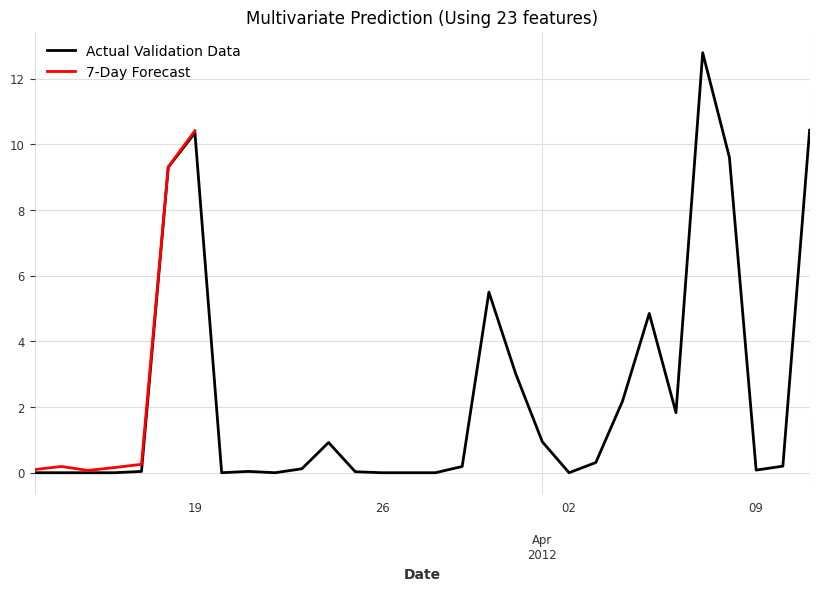

In [31]:
# Plotting
plt.figure(figsize=(10, 6))
# Plot actual validation data (unscaled) for comparison
val_target_unscaled = target_scaler.inverse_transform(val_target)
val_target_unscaled[:30].plot(label='Actual Validation Data') # Plot first 30 days of val
pred.plot(label='7-Day Forecast', color='red')
plt.title(f'Multivariate Prediction (Using {len(covariates_series.components)} features)')
plt.legend()
plt.show()